In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt



## Discretization parameters

In [2]:
# domain length
l = 1
# number of elements
n_el = 200

# element size
h = l/n_el
# number of nodes
n_no = n_el+1
# nodes coordinates
X = np.linspace(0,1,n_no)
# integration points coordinates
Xg = 0.5*( X[:-1] + X[1:] )

## Distributions that define the problem

In [3]:
# target temperature
T_star = np.ones(X.shape) + (X/l)**2

In [4]:
# initial design vector that parameterizes heat sources
dim_opt = 6
Var_ini = np.full(dim_opt,0)

In [5]:
# conduction coefficient with possible noise

rng = np.random.default_rng(seed=2024)

def compute_conduction(noise_val):

    noise = rng.random(Xg.shape) * noise_val

    K = np.ones(Xg.shape) +  0.4*np.sin(4*np.pi*Xg/l) +  0.3*np.sin(12*np.pi*Xg/l) + noise
    
    return K

# without noise
K_ref = compute_conduction(0)

Text(0, 0.5, 'conduction coefficient')

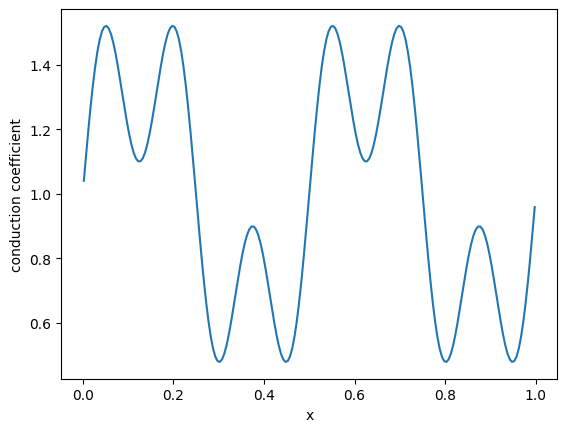

In [6]:
# plot of the conduction coefficient along x

plt.plot(Xg,K_ref)
plt.xlabel('x')
plt.ylabel('conduction coefficient')

## Parameterization of the heat source

In [7]:
def performBernstein(x,Var):
    
    n = len(Var)
    B = np.zeros(n)
    
    for i in range(n):
        B[i] = math.comb(n-1,i)*((1-x)**(n-1-i))*(x**i)*Var[i]
        
    return sum(B)

In [8]:
def compute_source(Var_opt):
    
    # by default zero source
    S = np.zeros(Xg.shape)
    
    for i in range(dim_opt):
        S[i] = performBernstein(Xg[i],Var_opt)
    
    return S

## Finite-Element tools for the analysis

In [9]:
def compute_matrix(K):

    # Finite-Element matrix initialisation
    M = np.zeros((n_no,n_no))
    
    # Boundary conditions
    M[0][0] = 1
    M[n_no-1][n_no-1] = 1
    
    # Internal coeff
    for i in range(1,n_no-1):
        M[i][i] = (K[i-1]+K[i])/h
        M[i][i-1] = -K[i-1]/h
        M[i][i+1] = -K[i]/h
        
    return M

In [10]:
def compute_rhs(S):

    # Finite-Element right-hand side initialisation
    Rhs = np.zeros((n_no,1))
    
    # Boundary conditions
    Rhs[0] = 1
    Rhs[n_no-1] = 2
    
    # internal coeff
    for i in range(1,n_no-1):
        Rhs[i] = (S[i-1]+S[i])*h/2
        
    return Rhs

In [11]:
def simulator(noise,Var):
    
    # conduction
    K = compute_conduction(noise)

    # matrix
    M = compute_matrix(K)
    
    # compute heat source
    Src = compute_source(Var)

    # right-hand side
    Rhs = compute_rhs(Src)

    # Finite-element solution
    T = np.matmul(np.linalg.inv(M),Rhs).reshape((n_no))
    
    return T

In [12]:
def costFunction():
    return 0.5*sum((T_ini-T_star)**2)*h

## Test for initial configuration

In [13]:
# solve the problem for initial conditions

T_ini = simulator(0,Var_ini)


AttributeError: module 'math' has no attribute 'comb'

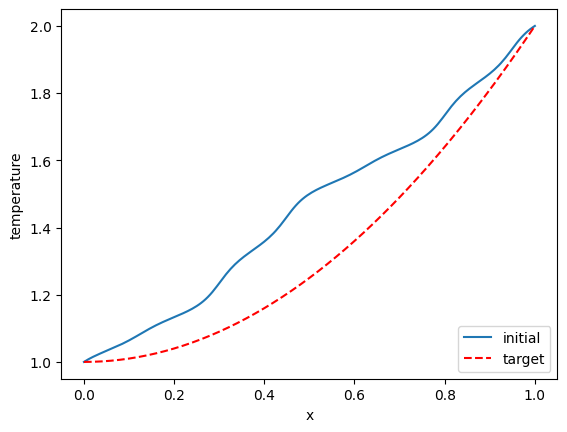

In [14]:
# plot of initial temperature along x

plt.plot(X,T_ini)
plt.plot(X,T_star,'r--')
plt.xlabel('x')
plt.ylabel('temperature')
plt.legend(["initial", "target"], loc="lower right")
print(performBernstein(0.5,Var_ini))